<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2022-1/06_Classifica%C3%A7%C3%A3o_D%C3%ADgitos_BDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

import sklearn
print ( sklearn.__version__ )

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

1.0.2


In [2]:
train_model = True
run_grid_search = True
save_model = True

model_path = "ada_clf.joblib"

### Amostra de dígitos

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
X_train_raw = mnist.data[:60000]
y_train = mnist.target[:60000]
X_test_raw = mnist.data[60000:]
y_test = mnist.target[60000:]

print ( X_train_raw.shape )
print ( X_test_raw.shape )

(60000, 784)
(10000, 784)


### Renormalização dos dados

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train_raw )
X_test  = scaler.transform( X_test_raw )
idx = 20000
print ( y_train[ idx ] )
print ( X_train[ idx ] )

3
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00441808 -0.00575482 -0.00408252 -0.00408252  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00408252 -0.00470969 -0.00879935 -0.01159056
 -0.01475898 -0.01928485 -0.0246718  -0.02907103 -0.03059266 -0.03116401
 -0.03196287 -0.03020254 -0.03131022 -0.0283834  -0.02311919 -0.01916663
 -0.0167723  -0.01099636 -0.00832486 -0.00438069  0.          0.
  0.          0.          0.          0.         -0.00408252 -0.00539535
 -0.00852241 -0.01198504 -0.01765348 -0.0277109  -0.03702009 -0.05215128
 -0.0670362  -0.08301705 -0.0993793  -0.11518413 -0.12913326 -0.13839468
 -0.13888363 -0.13184344 -0.12042952 -0.10189079 -0.0786049  -0.05699561
 -0.03965768 -0.02372839 -0.01408835 -0.00783084  0.          0.
  0.          0.         -0.0053

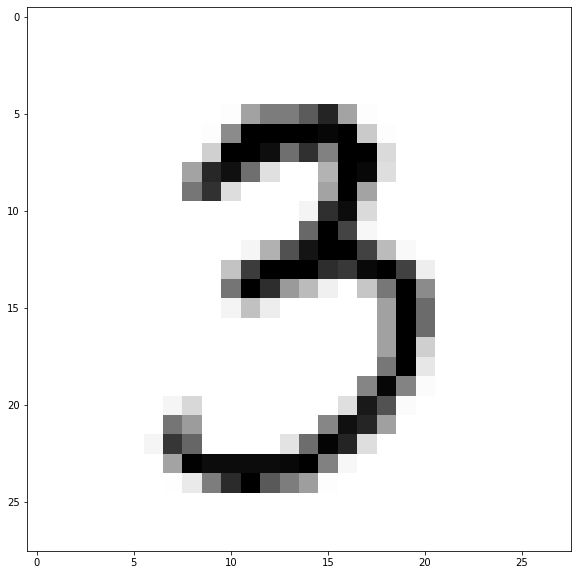

In [5]:
fig = plt.figure( figsize=(10,10) )
plt.imshow( X_train_raw[ idx ].reshape(28,28), cmap='binary' )

### Treinamento
### Hyperparameter scan

In [6]:
shuffle_index = np.random.permutation( 60000 )
X_train_shuffle, y_train_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ]

In [7]:
X_train_shuffle, y_train_shuffle = X_train_shuffle[:10000], y_train_shuffle[:10000]

n_iter_search = 5 # número de configurações de parâmetros
cv = 4 # cross validation samples

grid_search = None
if train_model and run_grid_search:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    from sklearn.model_selection import RandomizedSearchCV
    #from sklearn.model_selection import GridSearchCV

    param_distribs = {
        "base_estimator__max_depth": np.arange(2,5),
        "base_estimator__min_samples_split": np.arange(2,5),
        "n_estimators": 100 * np.arange(2,6),
        "learning_rate": 0.1 * np.arange(2,6)
        }

    grid_search = RandomizedSearchCV(
        AdaBoostClassifier(
            DecisionTreeClassifier(),
            algorithm="SAMME.R"
            ),
        param_distribs,
        n_iter=n_iter_search, cv=cv, verbose=20, n_jobs=-1, random_state=42
        )
    grid_search.fit( X_train_shuffle, y_train_shuffle )

    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    print ( grid_search.cv_results_ )
    
    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2022/04/08 23:54:46
Fitting 4 folds for each of 5 candidates, totalling 20 fits
{'n_estimators': 300, 'learning_rate': 0.30000000000000004, 'base_estimator__min_samples_split': 3, 'base_estimator__max_depth': 4}
0.8947
{'mean_fit_time': array([259.94487226, 241.07015377, 269.73433828, 255.0106439 ,
       134.30173612]), 'std_fit_time': array([11.42822895,  1.35061967,  2.04606314,  5.5823962 ,  3.81041422]), 'mean_score_time': array([2.75857675, 4.37895739, 3.4148261 , 2.61468065, 1.53911346]), 'std_score_time': array([0.3989528 , 0.02934748, 0.08363722, 0.22999667, 0.27310963]), 'param_n_estimators': masked_array(data=[300, 500, 400, 300, 200],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.30000000000000004, 0.2, 0.2, 0.2, 0.4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_base_estimator__min_samples_split': masked_a

### Modelo

In [8]:
model_final = None

if train_model:
    if run_grid_search: 
        model_final = grid_search.best_estimator_
    else:
        model_final = AdaBoostClassifier(
                DecisionTreeClassifier(
                    max_depth=4,
                    min_samples_split=3
                ),
                n_estimators = 300,
                algorithm="SAMME.R",
                learning_rate = 0.3
                )
        model_final.fit( X_train_shuffle, y_train_shuffle )
else:
    model_final = load( model_path )
 
print ( model_final )

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4,
                                                         min_samples_split=3),
                   learning_rate=0.30000000000000004, n_estimators=300)


### Teste

In [9]:
y_predict_test = model_final.predict( X_test )

accuracy = np.sum( y_predict_test == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

Accuracy = 0.9101


In [11]:
if train_model and save_model:
    dump( model_final, "ada_clf.joblib" )

In [12]:
np.info( DecisionTreeClassifier )

 DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None,
                        min_samples_split=2, min_samples_leaf=1,
                        min_weight_fraction_leaf=0.0, max_features=None,
                        random_state=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, class_weight=None,
                        ccp_alpha=0.0)

A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
